In [19]:
# 1. LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import joblib

warnings.filterwarnings("ignore")

In [20]:
# 2. LOAD DATA

df = pd.read_csv('/content/data.csv')

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")
df.set_index("date", inplace=True)

print(df.head())
print(df.info())

            orders  temperature  media_spend
date                                        
2020-05-02      54    18.270322          0.0
2020-05-03      63    19.882444          0.0
2020-05-04      56    16.878095          0.0
2020-05-05      65    21.878648          0.0
2020-05-06      64    21.112398          0.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790 entries, 2020-05-02 to 2022-06-30
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   orders       790 non-null    int64  
 1   temperature  769 non-null    float64
 2   media_spend  790 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 24.7 KB
None


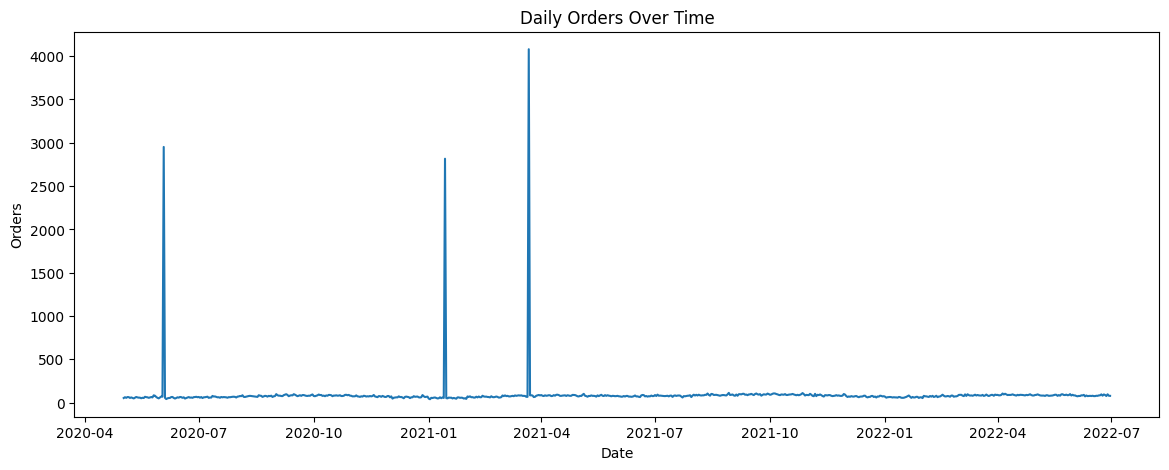

In [21]:
# 3. INITIAL VISUALIZATION
plt.figure(figsize=(14,5))
plt.plot(df.index, df["orders"])
plt.title("Daily Orders Over Time")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.show()

In [22]:
# 4. MISSING VALUE HANDLING
df[["orders", "temperature", "media_spend"]] = df[
    ["orders", "temperature", "media_spend"]
].fillna(method="ffill")

df.dropna(inplace=True)

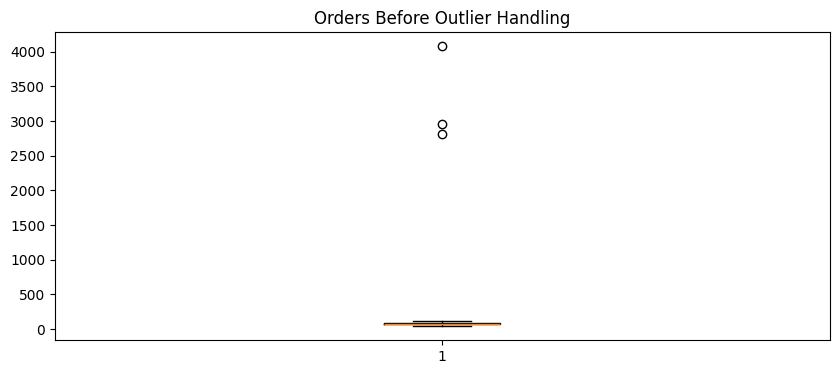

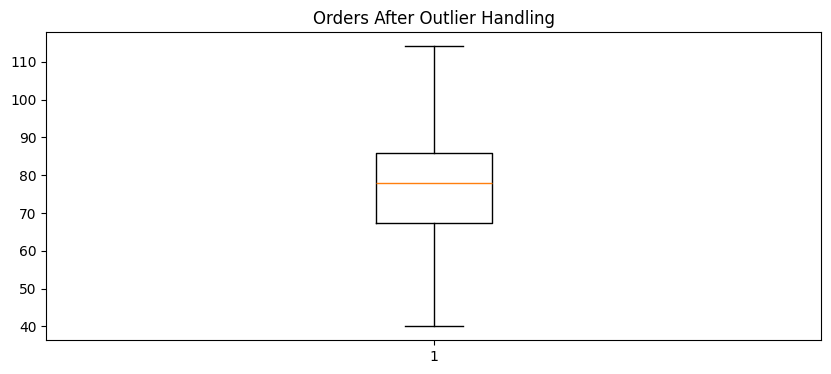

In [23]:
# 5. OUTLIER HANDLING (IQR)
def remove_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return series.clip(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

plt.figure(figsize=(10,4))
plt.boxplot(df["orders"])
plt.title("Orders Before Outlier Handling")
plt.show()

df["orders"] = remove_outliers_iqr(df["orders"])

plt.figure(figsize=(10,4))
plt.boxplot(df["orders"])
plt.title("Orders After Outlier Handling")
plt.show()

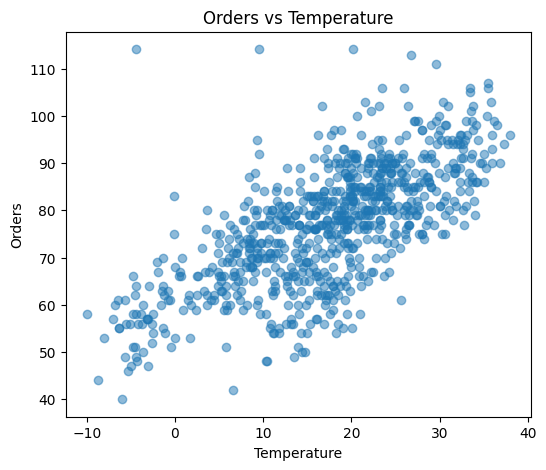

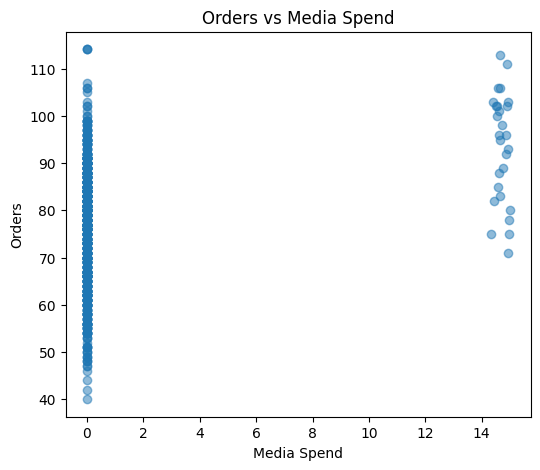

In [24]:
# 6. FEATURE RELATIONSHIPS
plt.figure(figsize=(6,5))
plt.scatter(df["temperature"], df["orders"], alpha=0.5)
plt.title("Orders vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Orders")
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(df["media_spend"], df["orders"], alpha=0.5)
plt.title("Orders vs Media Spend")
plt.xlabel("Media Spend")
plt.ylabel("Orders")
plt.show()

In [25]:
# 7. STATIONARITY CHECK (ADF)
adf_result = adfuller(df["orders"])
print("ADF p-value:", adf_result[1])

ADF p-value: 0.10512586080353886


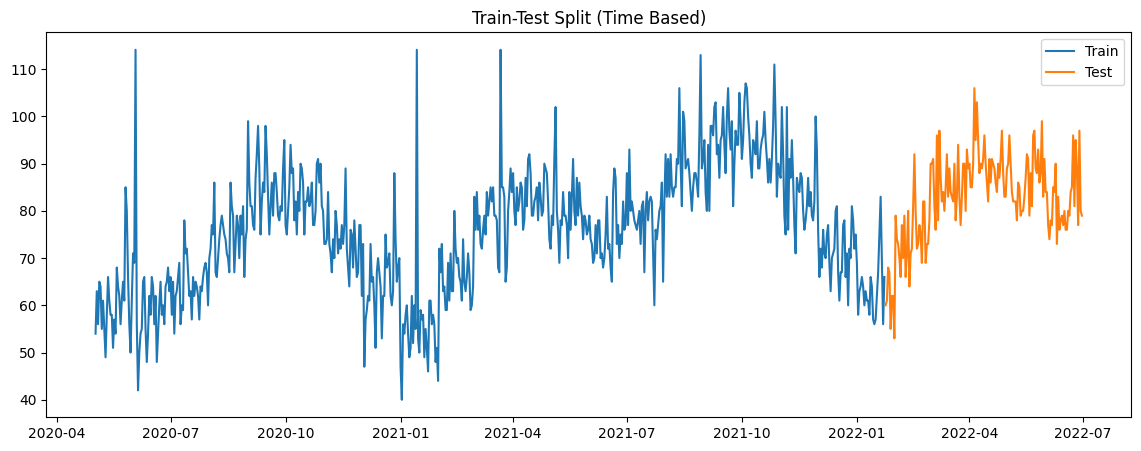

In [26]:
# 8. TRAIN - TEST SPLIT (TIME BASED)
test_size = int(len(df) * 0.2)

train = df.iloc[:-test_size]
test = df.iloc[-test_size:]

y_train = train["orders"]
y_test = test["orders"]

exog_train = train[["temperature", "media_spend"]]
exog_test = test[["temperature", "media_spend"]]

plt.figure(figsize=(14,5))
plt.plot(train.index, train["orders"], label="Train")
plt.plot(test.index, test["orders"], label="Test")
plt.title("Train-Test Split (Time Based)")
plt.legend()
plt.show()

In [27]:
# 9. TIME SERIES CROSS VALIDATION + PARAMETER SEARCH
tscv = TimeSeriesSplit(n_splits=5)

best_rmse = np.inf
best_order = None
best_seasonal = None

for order in [(1,1,1), (2,1,2), (3,1,3)]:
    for seasonal in [(1,1,1,7), (1,1,1,12)]:
        rmses = []

        for train_idx, val_idx in tscv.split(y_train):
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            ex_tr, ex_val = exog_train.iloc[train_idx], exog_train.iloc[val_idx]

            model = SARIMAX(
                y_tr,
                exog=ex_tr,
                order=order,
                seasonal_order=seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )

            result = model.fit(disp=False)
            preds = result.predict(
                start=y_val.index[0],
                end=y_val.index[-1],
                exog=ex_val
            )

            rmse = np.sqrt(mean_squared_error(y_val, preds))
            rmses.append(rmse)

        avg_rmse = np.mean(rmses)

        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_order = order
            best_seasonal = seasonal

print("Best Order:", best_order)
print("Best Seasonal:", best_seasonal)

Best Order: (3, 1, 3)
Best Seasonal: (1, 1, 1, 7)


In [28]:
# 10. FINAL MODEL TRAINING
final_model = SARIMAX(
    y_train,
    exog=exog_train,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
)

final_result = final_model.fit()

In [29]:
# 11. TRAIN & TEST PREDICTIONS
train_pred = final_result.predict(
    start=y_train.index[0],
    end=y_train.index[-1],
    exog=exog_train
)

test_pred = final_result.predict(
    start=y_test.index[0],
    end=y_test.index[-1],
    exog=exog_test
)

def print_metrics(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} RMSE: {rmse:.2f} | MAE: {mae:.2f}")

print_metrics(y_train, train_pred, "TRAIN")
print_metrics(y_test, test_pred, "TEST")

TRAIN RMSE: 5.72 | MAE: 3.51
TEST RMSE: 3.51 | MAE: 2.73


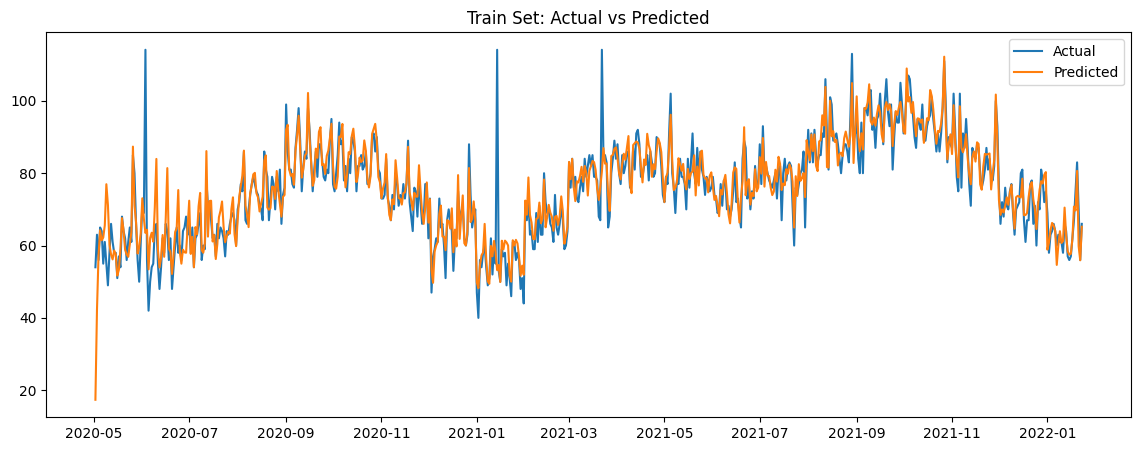

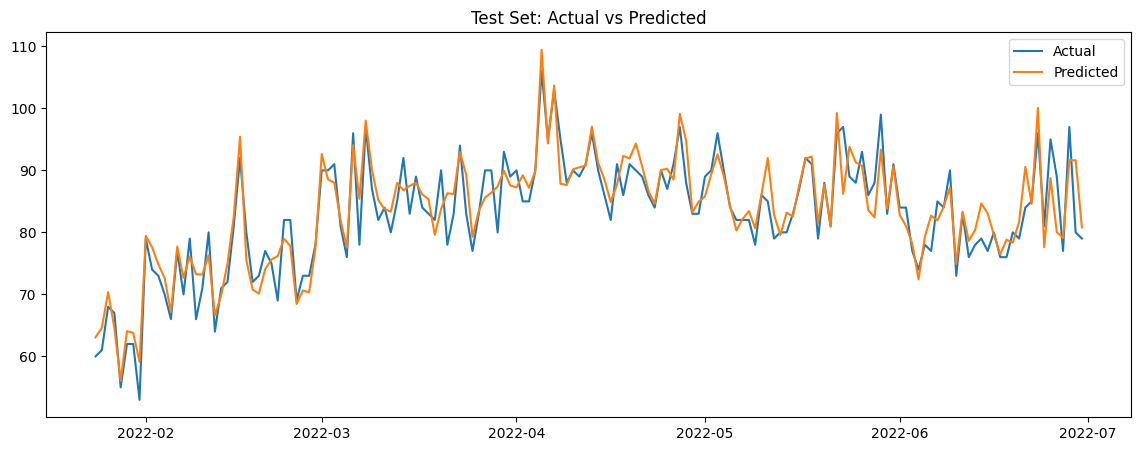

In [30]:
# 12. VISUALIZE MODEL PERFORMANCE
plt.figure(figsize=(14,5))
plt.plot(y_train.index, y_train, label="Actual")
plt.plot(y_train.index, train_pred, label="Predicted")
plt.title("Train Set: Actual vs Predicted")
plt.legend()
plt.show()

plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, test_pred, label="Predicted")
plt.title("Test Set: Actual vs Predicted")
plt.legend()
plt.show()

In [31]:
# 13. REFIT MODEL WITH FULL DATA (FOR FORECASTING)
full_y = df["orders"]
full_exog = df[["temperature", "media_spend"]]

final_model_full = SARIMAX(
    full_y,
    exog=full_exog,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
)

final_result_full = final_model_full.fit()

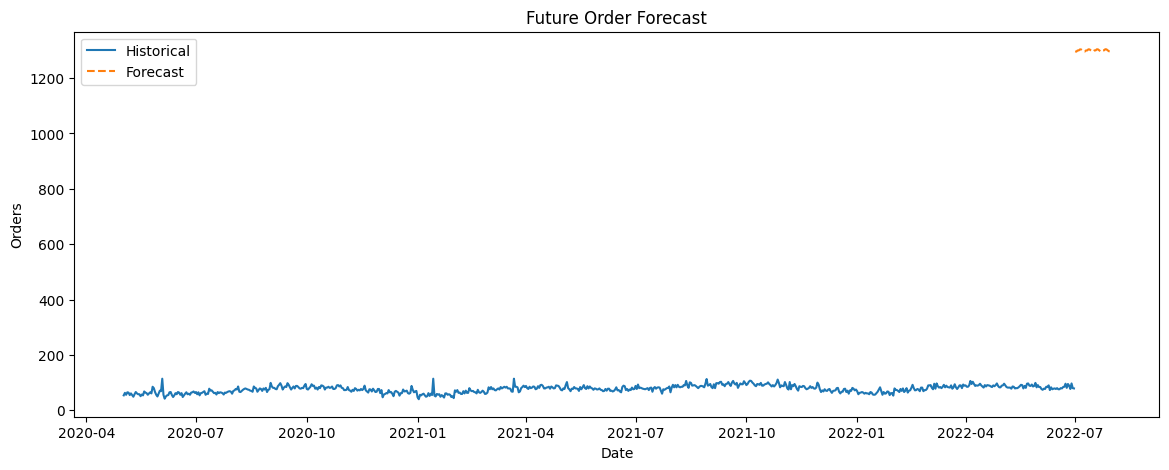

In [32]:
# 14. FUTURE FORECASTING
forecast_horizon = 30

future_dates = pd.date_range(
    start=df.index[-1] + pd.Timedelta(days=1),
    periods=forecast_horizon,
    freq="D"
)

future_exog = pd.DataFrame({
    "temperature": [5] * forecast_horizon,
    "media_spend": [1200] * forecast_horizon
}, index=future_dates)

forecast_results = final_result_full.get_forecast(
    steps=forecast_horizon,
    exog=future_exog
)

forecast = forecast_results.predicted_mean

plt.figure(figsize=(14,5))
plt.plot(df.index, df["orders"], label="Historical")
plt.plot(forecast.index, forecast, linestyle="--", label="Forecast")
plt.title("Future Order Forecast")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.legend()
plt.show()

In [33]:
# 15. SAVE FINAL MODEL
joblib.dump(final_result_full, "order_forecast_sarimax.pkl")

print("Model saved successfully.")

Model saved successfully.
